In [ ]:
# Cài đặt thư viện
!pip install unsloth datasets trl transformers torch torchvision diffusers accelerate googletrans==3.1.0a0





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.9/194.9 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.2 MB/s eta 0:00:00
   ━━

In [ ]:
# Import thư viện
from unsloth import FastLanguageModel
from datasets import load_dataset
from trl import SFTTrainer
from transformers import TrainingArguments
from diffusers import StableDiffusionPipeline
import torch
from googletrans import Translator

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: OpenAI failed to import - ignoring for now.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
# Khởi tạo translator
translator = Translator()

# Prompt
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a detailed and creative book cover description based on the instruction and input.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

# Hàm định dạng dữ liệu
EOS_TOKEN = "<|eot_id|>"
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs = examples["input"]
    outputs = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return {"text": texts}


In [ ]:
# 1. Tải và tinh chỉnh Mistral-7B
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/mistral-7b-bnb-4bit",
    max_seq_length=2048,
    dtype=None,
    load_in_4bit=True,
)
model = FastLanguageModel.get_peft_model(
    model,
    r=64,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=3977,
)

==((====))==  Unsloth 2025.3.14: Fast Mistral patching. Transformers: 4.48.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.3.14 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [ ]:
# Tải dữ liệu
dataset = load_dataset("csv", data_files="/content/Cover.csv", split="train")
dataset = dataset.map(formatting_prompts_func, batched=True)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/302 [00:00<?, ? examples/s]

In [ ]:
# Huấn luyện
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    dataset_text_field="text",
    max_seq_length=2048,
    dataset_num_proc=2,
    packing=False,
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=20,
        max_steps=100,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=10,
        optim="adamw_8bit",
        weight_decay=0.05,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to="none",
    ),
)
trainer.train()

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/302 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 302 | Num Epochs = 3 | Total steps = 100
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 167,772,160/7,000,000,000 (2.40% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,1.557000
20,0.948500
30,0.793900
40,0.796500
50,0.539100
60,0.527900
70,0.526600
80,0.449300
90,0.346800
100,0.310300


TrainOutput(global_step=100, training_loss=0.6795960712432861, metrics={'train_runtime': 919.2986, 'train_samples_per_second': 0.87, 'train_steps_per_second': 0.109, 'total_flos': 9411624295317504.0, 'train_loss': 0.6795960712432861})

In [ ]:
# Lưu mô hình và tokenizer
model.save_pretrained("saved_mistral_7b_model")
tokenizer.save_pretrained("saved_mistral_7b_model")
print("Đã lưu mô hình và tokenizer tại 'saved_mistral_7b_model'")

Đã lưu mô hình và tokenizer tại 'saved_mistral_7b_model'


In [ ]:
# 2. Chuẩn bị suy luận
FastLanguageModel.for_inference(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
     

In [ ]:
def generate_book_cover_description(book_info, style_input=""):
    inputs = tokenizer(
        [alpaca_prompt.format(f"Tạo mô tả bìa sách cho: {book_info}", style_input, "")],
        return_tensors="pt"
    ).to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=150,
        use_cache=True,
        temperature=0.9,
        top_p=0.7,
        do_sample=True
    )
    raw_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Xử lý đầu ra
    if "### Response:" in raw_output:
        description_vi = raw_output.split("### Response:")[1].strip()
    else:
        description_vi = raw_output.strip()

    # Cắt bỏ mọi thứ sau dấu chấm cuối cùng
    if '.' in description_vi:
        description_vi = description_vi[:description_vi.rindex('.') + 1].strip()

    # Dịch sang tiếng Anh
    description_en = translator.translate(description_vi, src="vi", dest="en").text
    # Cắt bỏ mọi thứ sau dấu chấm cuối cùng trong tiếng Anh
    if '.' in description_en:
        description_en = description_en[:description_en.rindex('.') + 1].strip()

    return description_vi, description_en

In [ ]:
# 4. Kiểm tra
test_cases = [
    {"book_info": "ngôi nhà nhỏ trên biển", "style_input": ""},
    {"book_info": "Sách khoa học viễn tưởng ", "style_input": "phong cách tương lai"},
    {"book_info": "Truyện về một chú mèo phiêu lưu", "style_input": "màu sắc tươi sáng"},
    {"book_info": "Truyện lãng mạn về tình yêu mùa đông", "style_input": "màu sắc ấm áp"},
]

print("Kiểm tra mô tả bìa sách từ mô hình:")
for test in test_cases:
    description_vi, description_en = generate_book_cover_description(test["book_info"], test["style_input"])
    print(f"\nBook Info: {test['book_info']}")
    print(f"Style Input: {test['style_input']}")
    print(f"Mô tả bìa (tiếng Việt): {description_vi}")
    print(f"Mô tả bìa (tiếng Anh): {description_en}")

Kiểm tra mô tả bìa sách từ mô hình:

Book Info: ngôi nhà nhỏ trên biển
Style Input: 
Mô tả bìa (tiếng Việt): Một ngôi nhà nhỏ nằm giữa biển vô tận, cửa sổ phản chiếu nét vũng rực rỡ, những con voi biển lơ lửng trên bờ biển xa.
Mô tả bìa (tiếng Anh): A small house lying in the middle of the endless sea, the window reflected the brilliant pools, the sea elephants floated on the far coast.

Book Info: Sách khoa học viễn tưởng 
Style Input: phong cách tương lai
Mô tả bìa (tiếng Việt): Một người đàn ông đứng trước một cánh cổng phát sáng, bên ngoài là thế giới xa lạ với những loài sinh vật kỳ lạ.
Mô tả bìa (tiếng Anh): A man stands in front of a glowing gate, outside is a strange world with strange creatures.

Book Info: Truyện về một chú mèo phiêu lưu
Style Input: màu sắc tươi sáng
Mô tả bìa (tiếng Việt): Một chú mèo đứng trên cầu thang gỗ, phía xa là một cánh cửa mở ra ánh sáng đầy lấp lánh.
Mô tả bìa (tiếng Anh): A cat standing on a wooden staircase, in the distance is a door that opens 

In [ ]:
from diffusers import StableDiffusionPipeline
import torch
from IPython.display import Image, display

In [ ]:
# 5. Sinh ảnh từ mô tả bằng Stable Diffusion v2.1
def generate_image_from_description(description_en, output_path="generated_image.png"):
    # Tải mô hình Stable Diffusion v2.1
    pipe = StableDiffusionPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-1",
        torch_dtype=torch.float16,  # Sử dụng FP16 để tiết kiệm VRAM
        use_safetensors=True        # Dùng định dạng safetensors cho tốc độ và an toàn
    )
    pipe = pipe.to("cuda")  # Chuyển sang GPU

    # Tối ưu hóa để chạy trên Colab
    pipe.enable_attention_slicing()         # Giảm tiêu thụ bộ nhớ
    pipe.enable_sequential_cpu_offload()    # Tận dụng CPU khi VRAM đầy

    # Sinh ảnh từ mô tả
    image = pipe(
        description_en,
        num_inference_steps=50,  # 50 bước để cân bằng chất lượng và tốc độ
        guidance_scale=7.5,      # Độ bám sát prompt
        height=512,              # Độ phân giải 512x512
        width=512
    ).images[0]

    # Lưu ảnh
    image.save(output_path)
    print(f"Đã lưu ảnh tại: {output_path}")
    return image

In [ ]:
# 6. Nhập văn bản từ bàn phím và sinh mô tả + ảnh
print("Nhập thông tin để tạo mô tả bìa sách và ảnh:")

# Sử dụng input của Colab
book_info = input("Nhập thông tin sách (ví dụ: 'ngôi nhà ma ám giữa rừng cây'): ")
style_input = input("Nhập phong cách (ví dụ: 'phong cách kinh dị, tông màu tối'): ")

# Sinh mô tả
description_vi, description_en = generate_book_cover_description(book_info, style_input)
print(f"\nBook Info: {book_info}")
print(f"Style Input: {style_input}")
print(f"Mô tả bìa (tiếng Việt): {description_vi}")
print(f"Mô tả bìa (tiếng Anh): {description_en}")

Nhập thông tin để tạo mô tả bìa sách và ảnh:
Nhập thông tin sách (ví dụ: 'ngôi nhà ma ám giữa rừng cây'): bầu trời đêm trên bãi biển
Nhập phong cách (ví dụ: 'phong cách kinh dị, tông màu tối'): 

Book Info: bầu trời đêm trên bãi biển
Style Input: 
Mô tả bìa (tiếng Việt): Một ngôi nhà gỗ cũ trên biển, cửa sổ phản chiếu lên bầu trời đêm, những ngôi sao lấp lánh.
Mô tả bìa (tiếng Anh): An old wooden house on the sea, the window reflected on the night sky, sparkling stars.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

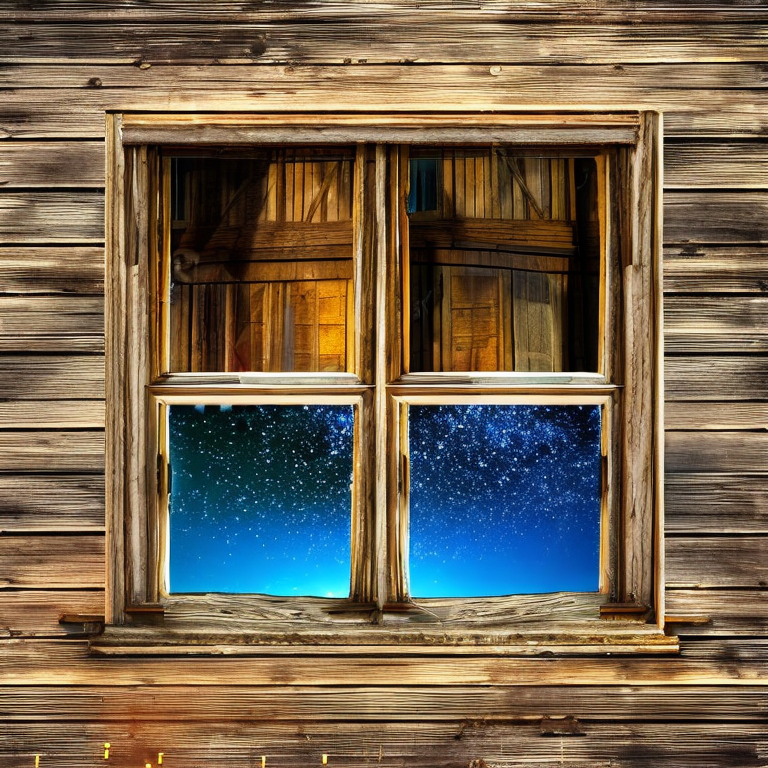


Book Info: ngôi nhà nhỏ trên bãi biển
Style Input: 
Mô tả bìa (tiếng Việt): Một ngôi nhà nhỏ với đều bầu trời với đường dây đến phía bờ biển.
Mô tả bìa (tiếng Anh): A small house with the sky with a line to the coast.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

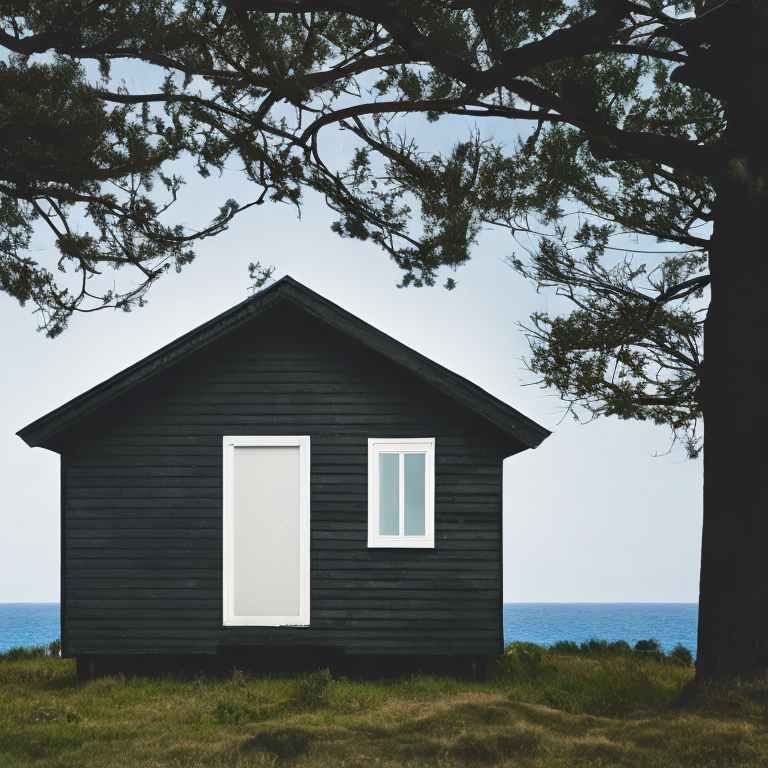

Vui lòng nhập 'yes' hoặc 'no'.


In [ ]:
           # Sinh ảnh từ mô tả tiếng Anh
output_image_path = f"generated_image_{book_info.replace(' ', '_')}.png"
generated_image = generate_image_from_description(description_en, output_image_path)

# Hiển thị ảnh
display(Image(filename=output_image_path))

# Hỏi người dùng có muốn tiếp tục không
while True:
    continue_choice = input("Bạn có muốn tạo thêm mô tả và ảnh khác không? (yes/no): ").lower()
    if continue_choice == "yes":
        book_info = input("Nhập thông tin sách: ")
        style_input = input("Nhập phong cách: ")

        description_vi, description_en = generate_book_cover_description(book_info, style_input)
        print(f"\nBook Info: {book_info}")
        print(f"Style Input: {style_input}")
        print(f"Mô tả bìa (tiếng Việt): {description_vi}")
        print(f"Mô tả bìa (tiếng Anh): {description_en}")

        output_image_path = f"generated_image_{book_info.replace(' ', '_')}.png"
        generated_image = generate_image_from_description(description_en, output_image_path)
        display(Image(filename=output_image_path))
    elif continue_choice == "no":
        print("Đã kết thúc!")
        break
    else:
        print("Vui lòng nhập 'yes' hoặc 'no'.")